# Grant Ferrel

"On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

# Project Overview

As we welcome in a new era of marketing, many companies (Netflix, target, Amazon for example) are exploring a new frontier of providing extremely personalized ads targeted at individual consumers based on purchasing history and location. This project aims to analyze online comments (via twitter and review pages) along with the current events news to develop the most effective marketing strategy based on region. 

*Note: Considering the time frame for this project, I will only be focusing on a marketing campeign specifically targeting Kansas Home Depot customers. This approach can then be expanded to account for the entire US for real world application.*

# 1. Import Required Packages

In [90]:
# Import packages
import csv
import pandas as pd
import re
import json
import requests
from lxml import html
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

# import nltk 
import nltk

# stopwords, FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Import Wordcloud packages
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

# Tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

# 2. Collect Tweets

Collect tweets from Homedepot twitter handle and all twitter mentions of HomeDepot...

In [91]:
# Collect tweets from @HomeDepot.

import tweepy
import csv

#Variables that contains the user credentials to access Twitter API
consumer_key = 'bX8WtdI5T9dya3BohMslmVGkF'
consumer_secret = 'EBaqCEsHLTanzEYfhEnrsiDUy46ULg0ONMUwqVezKiE0sUJ4Xz'
access_key = '1087942803647270913-3U8GubNvGZ2KNRdZ2oEietBl9pHbOj'
access_secret = 'Yn9p0JL9P65LZpYR40ryvP5vi9CZi5jvilMqRK15eHr9R'

# Twitter only allows access to a users most recent 3240 tweets with this method

# Authorize twitter, initialize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

openfile = open("data/HD_Tweets.csv", "r")
r = csv.reader(openfile)

writefile=open("data/HD_Tweets.csv", "w", encoding='UTF-8', newline='')
w=csv.writer(writefile)

# counter = 0

for i in r:
    #initialize a list to hold all the tweepy Tweets
    alltweets = []
    print(i[0])

    try:
        new_tweets = api.user_timeline(screen_name = i[0], count=200, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    except:
        pass
    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    try:
        oldest = alltweets[-1].id - 1
    except:
        pass

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print("getting tweets before %s" % (oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        try:
            new_tweets = api.user_timeline(screen_name = i[0],count=200,max_id=oldest, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        except:
            pass
        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print("...%s tweets downloaded so far" % (len(alltweets)))

    #counter += 1
        #write the csv
    for tweet in alltweets:
        w.writerow([i[0], tweet.id_str, tweet.created_at, tweet.text])
        writefile.flush()

openfile.close()
writefile.close()

# 3. Crawl/Mine Relevent Websites

### 3.1 Mine weather service website for Kansas weather information....

In [92]:
# Pull state specific Url's for local weather forcast.
r = requests.get('https://www.kwch.com/weather/alerts/')
data = html.fromstring(r.text)

# Create empty list for mined information.
weather = []

# Mine Website
for i in data.xpath("//div[@class='col-sm-24 col-md-17 leftColumn']"):
    county = i.xpath("div[@class='alertTitle']/p[1]/text()")
    print(county)
    weather.append([county])


[' Alfalfa; Blaine; Custer; Dewey; Ellis; Garfield; Grant; Kay; Kingfisher; Logan; Major; Noble; Payne; Roger Mills; Woodward', ' Alfalfa; Ellis; Grant; Harper; Kay; Woods; Woodward', ' Allen; Barton; Butler; Chase; Chautauqua; Cowley; Elk; Ellsworth; Greenwood; Harper; Harvey; Kingman; Labette; Lincoln; Marion; McPherson; Montgomery; Neosho; Reno; Rice; Russell; Saline; Sedgwick; Sumner; Wilson; Woodson', ' Anderson; Brown; Clay; Cloud; Coffey; Dickinson; Douglas; Franklin; Geary; Jackson; Jefferson; Lyon; Marshall; Morris; Nemaha; Osage; Ottawa; Pottawatomie; Republic; Riley; Shawnee; Wabaunsee; Washington', ' Barber; Butler; Chautauqua; Clark; Comanche; Cowley; Edwards; Elk; Ford; Gray; Greenwood; Harper; Haskell; Kingman; Kiowa; Meade; Pratt; Sedgwick; Seward; Sumner', ' Barber; Clark; Comanche; Edwards; Ford; Hodgeman; Kiowa; Meade; Pawnee; Pratt; Rush; Stafford', ' Beaver', ' Beaver; Texas', ' Butler', ' Butler', ' Clark', ' Cowley', ' Harper; Woods', ' Jewell; Mitchell; Osborne;

### 3.2 Mine trustpilot for HomeDepot reviews

In [93]:
# Web mine for customer reviews... check website crawling
web = "https://www.trustpilot.com/review/www.homedepot.com?page="

for page in range(1,10):
    print(web + str(page))

https://www.trustpilot.com/review/www.homedepot.com?page=1
https://www.trustpilot.com/review/www.homedepot.com?page=2
https://www.trustpilot.com/review/www.homedepot.com?page=3
https://www.trustpilot.com/review/www.homedepot.com?page=4
https://www.trustpilot.com/review/www.homedepot.com?page=5
https://www.trustpilot.com/review/www.homedepot.com?page=6
https://www.trustpilot.com/review/www.homedepot.com?page=7
https://www.trustpilot.com/review/www.homedepot.com?page=8
https://www.trustpilot.com/review/www.homedepot.com?page=9


In [94]:
# Create empty bin for trustpilot review collection.

reviews = []

# crawl multiple pages (9 pages -180 reviews)
web = "https://www.trustpilot.com/review/www.homedepot.com?page="
# Run for loop to pull data trustpilot pages 1-10.
for page in range(1,10):
    url = web + str(page)
    data = html.fromstring(requests.get(url).text)

# collect title and review
    for i in data.xpath("//div[@class='review-content__body']"):
        title = (i.xpath("h2/a/text()"))  
        review = (i.xpath("p/text()"))
        reviews.append([title, review])

# Show number of reviews contained within reviews list.
print(len(reviews))

180


### 3.3 Load all Kansas HomeDepot Locations

In [95]:
# Load data saved to CSV file. (https://www.homedepot.com/l/KS)
openfile = open("data/HD_stores.csv", "r")
r = csv.reader(openfile)
stores = []
for i in r:
    stores.append(i)
openfile.close()

### 3.4 Load Kansas County Statistical Data

In [96]:
# Load data saved to CSV file. (https://en.wikipedia.org/wiki/List_of_Kansas_locations_by_per_capita_income)
openfile = open("data/Kansas_County_Data.csv", "r")
r = csv.reader(openfile)
KS_data = []
for i in r:
    KS_data.append(i)
openfile.close()

# 4. Clean Data

### 4.1 Clean Trustpilot Data

Create data frame for trustpilot reviews...

In [97]:
# Create Data Frame for reviews
reviews = pd.DataFrame(reviews)
reviews.head(2)

,0,1
0,[Amazing],[\n I love the wood section!I found the perfect sizes for the shed I want to build in my backyard! I love that I can rely on Home Depot to have everything I need for building.\n ]
1,[Appliance Suite -- Nightmare],"[\n We purchased a suite of 4 appliances in November. 3 of them were installed incorrectly. The hardware holding the microwave in the cabinet over the range was stripped, causing a potential of the microwave falling. The refrigerator had the water line kinked in the back of the refrigerator causing the refrigerator to malfunction. After numerous service calls, this was finally discovered. The dishwasher was set to start automatically when it was installed causing us to struggle to figure out how to stop it, and that caused it to lock making it inoperable with a full load of dirty dishes. There have been about 10 service calls overall since November causing us to take off of work for their 4 hour window. The last service call, after waiting 5 hours and calling twice to check on the technician, was a no-show. No apologies from them. Today, they came to replace the defective refrigerator. They sent a team from the store to pick up the old refrigerator. They arrived without tools, and scratched our hardwood floor very badly. We asked them to put something down to protect the floor, and they refused. When I called the assistant manager at the store, he said all he could do was file an insurance claim. This is such a nightmare. Now I have to deal with an insurance company on my floor. Very poor customer service, and no responsibility for their actions.\n ]"


In [98]:
# Rename columns for review data frame. 
reviews = reviews.rename(columns={0: 'Overview', 1: 'Review'})
reviews.head(2)

,Overview,Review
0,[Amazing],[\n I love the wood section!I found the perfect sizes for the shed I want to build in my backyard! I love that I can rely on Home Depot to have everything I need for building.\n ]
1,[Appliance Suite -- Nightmare],"[\n We purchased a suite of 4 appliances in November. 3 of them were installed incorrectly. The hardware holding the microwave in the cabinet over the range was stripped, causing a potential of the microwave falling. The refrigerator had the water line kinked in the back of the refrigerator causing the refrigerator to malfunction. After numerous service calls, this was finally discovered. The dishwasher was set to start automatically when it was installed causing us to struggle to figure out how to stop it, and that caused it to lock making it inoperable with a full load of dirty dishes. There have been about 10 service calls overall since November causing us to take off of work for their 4 hour window. The last service call, after waiting 5 hours and calling twice to check on the technician, was a no-show. No apologies from them. Today, they came to replace the defective refrigerator. They sent a team from the store to pick up the old refrigerator. They arrived without tools, and scratched our hardwood floor very badly. We asked them to put something down to protect the floor, and they refused. When I called the assistant manager at the store, he said all he could do was file an insurance claim. This is such a nightmare. Now I have to deal with an insurance company on my floor. Very poor customer service, and no responsibility for their actions.\n ]"


In [99]:
# Remove brackets from 'Overview' and 'Review' column
reviews['Overview'] = reviews['Overview'].str[0]
reviews['Review'] = reviews['Review'].str[0]
reviews.head(2)

,Overview,Review
0,Amazing,\n I love the wood section!I found the perfect sizes for the shed I want to build in my backyard! I love that I can rely on Home Depot to have everything I need for building.\n
1,Appliance Suite -- Nightmare,"\n We purchased a suite of 4 appliances in November. 3 of them were installed incorrectly. The hardware holding the microwave in the cabinet over the range was stripped, causing a potential of the microwave falling. The refrigerator had the water line kinked in the back of the refrigerator causing the refrigerator to malfunction. After numerous service calls, this was finally discovered. The dishwasher was set to start automatically when it was installed causing us to struggle to figure out how to stop it, and that caused it to lock making it inoperable with a full load of dirty dishes. There have been about 10 service calls overall since November causing us to take off of work for their 4 hour window. The last service call, after waiting 5 hours and calling twice to check on the technician, was a no-show. No apologies from them. Today, they came to replace the defective refrigerator. They sent a team from the store to pick up the old refrigerator. They arrived without tools, and scratched our hardwood floor very badly. We asked them to put something down to protect the floor, and they refused. When I called the assistant manager at the store, he said all he could do was file an insurance claim. This is such a nightmare. Now I have to deal with an insurance company on my floor. Very poor customer service, and no responsibility for their actions.\n"


In [100]:
# Create a duplicate column of reviews for cleaning
reviews['Cleaned_Reviews'] = reviews['Review']
reviews.head(2)

,Overview,Review,Cleaned_Reviews
0,Amazing,\n I love the wood section!I found the perfect sizes for the shed I want to build in my backyard! I love that I can rely on Home Depot to have everything I need for building.\n,\n I love the wood section!I found the perfect sizes for the shed I want to build in my backyard! I love that I can rely on Home Depot to have everything I need for building.\n
1,Appliance Suite -- Nightmare,"\n We purchased a suite of 4 appliances in November. 3 of them were installed incorrectly. The hardware holding the microwave in the cabinet over the range was stripped, causing a potential of the microwave falling. The refrigerator had the water line kinked in the back of the refrigerator causing the refrigerator to malfunction. After numerous service calls, this was finally discovered. The dishwasher was set to start automatically when it was installed causing us to struggle to figure out how to stop it, and that caused it to lock making it inoperable with a full load of dirty dishes. There have been about 10 service calls overall since November causing us to take off of work for their 4 hour window. The last service call, after waiting 5 hours and calling twice to check on the technician, was a no-show. No apologies from them. Today, they came to replace the defective refrigerator. They sent a team from the store to pick up the old refrigerator. They arrived without tools, and scratched our hardwood floor very badly. We asked them to put something down to protect the floor, and they refused. When I called the assistant manager at the store, he said all he could do was file an insurance claim. This is such a nightmare. Now I have to deal with an insurance company on my floor. Very poor customer service, and no responsibility for their actions.\n","\n We purchased a suite of 4 appliances in November. 3 of them were installed incorrectly. The hardware holding the microwave in the cabinet over the range was stripped, causing a potential of the microwave falling. The refrigerator had the water line kinked in the back of the refrigerator causing the refrigerator to malfunction. After numerous service calls, this was finally discovered. The dishwasher was set to start automatically when it was installed causing us to struggle to figure out how to stop it, and that caused it to lock making it inoperable with a full load of dirty dishes. There have been about 10 service calls overall since November causing us to take off of work for their 4 hour window. The last service call, after waiting 5 hours and calling twice to check on the technician, was a no-show. No apologies from them. Today, they came to replace the defective refrigerator. They sent a team from the store to pick up the old refrigerator. They arrived without tools, and scratched our hardwood floor very badly. We asked them to put something down to protect the floor, and they refused. When I called the assistant manager at the store, he said all he could do was file an insurance claim. This is such a nightmare. Now I have to deal with an insurance company on my floor. Very poor customer service, and no responsibility for their actions.\n"


In [101]:
# Clean "Cleaned_Reviews" data for continued analysis.

# Convert reviews to lowercase
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].str.lower()
# remove commas
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].str.replace(',', '')
# Replace numbers and letters and use regular expression
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].str.replace(r'[^a-z0-9A-Z]', ' ')
# Remove short words (under 3 letters)
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].str.findall('\w{3,}').str.join(' ')
# remove anything other than English letters (# remove nonalphabetic characters)
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].apply(lambda x: re.sub("[^a-zA-Z]+", " ", x))
# remove numbers
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].str.replace('\d+', '')
# remove urls from tweets
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
# Remove stopwords
#https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe/43407993
more_stopwords = set(['the', 'and', 'this', 'that', 'was', 'said', 'set', 'put', 'file', 'with', 'you', 'one', 'for', 'but', '...', 'not', 'have', 'are', 'all', 'about', 'his', '[', ']', ',', '14', '0'])
extra_stoplist = set(stopwords.words('english')) | more_stopwords
reviews['Cleaned_Reviews'] = reviews.Cleaned_Reviews.apply(lambda x: ' '.join([word for word in x.split() if word not in (extra_stoplist)]))
# Split each review into tokens (using a lambda)
reviews['Cleaned_Reviews'] = reviews['Cleaned_Reviews'].apply(lambda x: x.split())

# Check cleaned data
reviews.head(2)

,Overview,Review,Cleaned_Reviews
0,Amazing,\n I love the wood section!I found the perfect sizes for the shed I want to build in my backyard! I love that I can rely on Home Depot to have everything I need for building.\n,"[love, wood, section, found, perfect, sizes, shed, want, build, backyard, love, rely, home, depot, everything, need, building]"
1,Appliance Suite -- Nightmare,"\n We purchased a suite of 4 appliances in November. 3 of them were installed incorrectly. The hardware holding the microwave in the cabinet over the range was stripped, causing a potential of the microwave falling. The refrigerator had the water line kinked in the back of the refrigerator causing the refrigerator to malfunction. After numerous service calls, this was finally discovered. The dishwasher was set to start automatically when it was installed causing us to struggle to figure out how to stop it, and that caused it to lock making it inoperable with a full load of dirty dishes. There have been about 10 service calls overall since November causing us to take off of work for their 4 hour window. The last service call, after waiting 5 hours and calling twice to check on the technician, was a no-show. No apologies from them. Today, they came to replace the defective refrigerator. They sent a team from the store to pick up the old refrigerator. They arrived without tools, and scratched our hardwood floor very badly. We asked them to put something down to protect the floor, and they refused. When I called the assistant manager at the store, he said all he could do was file an insurance claim. This is such a nightmare. Now I have to deal with an insurance company on my floor. Very poor customer service, and no responsibility for their actions.\n","[purchased, suite, appliances, november, installed, incorrectly, hardware, holding, microwave, cabinet, range, stripped, causing, potential, microwave, falling, refrigerator, water, line, kinked, back, refrigerator, causing, refrigerator, malfunction, numerous, service, calls, finally, discovered, dishwasher, start, automatically, installed, causing, struggle, figure, stop, caused, lock, making, inoperable, full, load, dirty, dishes, service, calls, overall, since, november, causing, take, work, hour, window, last, service, call, waiting, hours, calling, twice, check, technician, show, apologies, today, came, replace, defective, refrigerator, sent, team, store, pick, old, refrigerator, arrived, without, tools, scratched, hardwood, floor, badly, asked, something, protect, floor, refused, called, assistant, manager, store, could, insurance, claim, nightmare, deal, insurance, ...]"


### 4.2 Clean Store Location Data

Create data frame and edit information...

In [102]:
# Convert Stores list to data frame
stores = pd.DataFrame(stores)
stores.head(5)

,0,1,2,3,4,5,6
0,ï»¿E. Wichita,3350 N. Woodlawn,Wichita,Sedgwick,KS,67220,(316) 681-0899
1,Lawrence,1910 W. 31st Street,Lawrence,Douglas,KS,66046,(785) 749-2074
2,N. Overland Park,9600 Metcalf Ave.,Overland Park,Johnson,KS,66212,(913) 648-7811
3,S. Overland Park KS,8000 W. 135th St.,Overland Park,Johnson,KS,66223,(913) 851-9961
4,Garden City,3110 E. Kansas Ave.,Garden City,Finney,KS,67846,(620) 275-5943


In [103]:
# Rename data frame columns. 
stores = stores.rename(columns={0: 'Store', 1: 'Address', 2: 'City', 3: 'County', 4: 'State', 5: 'Zip', 6: 'Phone'})
stores.head(5)

,Store,Address,City,County,State,Zip,Phone
0,ï»¿E. Wichita,3350 N. Woodlawn,Wichita,Sedgwick,KS,67220,(316) 681-0899
1,Lawrence,1910 W. 31st Street,Lawrence,Douglas,KS,66046,(785) 749-2074
2,N. Overland Park,9600 Metcalf Ave.,Overland Park,Johnson,KS,66212,(913) 648-7811
3,S. Overland Park KS,8000 W. 135th St.,Overland Park,Johnson,KS,66223,(913) 851-9961
4,Garden City,3110 E. Kansas Ave.,Garden City,Finney,KS,67846,(620) 275-5943


### 4.3 Clean Kansas Weather Data

In [104]:
# Clean Kansas Storm weather data.

# Convert weather list to string
tokens = str(weather)
# Remove useless numbers and alphanumerical words
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)
#tokenization or word split
tokens = word_tokenize(tokens)

In [105]:
# Create Data frame from tokens.
weather = pd.DataFrame(tokens)
# Rename data frame columns. 
weather = weather.rename(columns={0: 'County'})
# Print first 5 entries of data frame
weather.head(5)

,County
0,Alfalfa
1,Blaine
2,Custer
3,Dewey
4,Ellis


### 4.4 Clean Kansas County Statistical Data

In [106]:
# In order to view entire column width, set to max
pd.set_option('display.max_colwidth', -1)

In [107]:
# Create Data Frame for KS_data 
KS_data = pd.DataFrame(KS_data)
KS_data.head(5)

,0,1,2,3,4,5,6
0,ï»¿1,Johnson,"$37,882","$73,733","$90,380","544,179","212,882"
1,2,Scott,"$28,872","$58,341","$65,000","4,936","1,983"
2,3,Greeley,"$28,698","$55,972","$63,967","1,247",525
3,4,Ness,"$27,622","$47,639","$55,875","3,107","1,365"
4,5,McPherson,"$26,467","$53,026","$68,016","29,180","11,748"


In [108]:
# Rename columns for review data frame. 
KS_data = KS_data.rename(columns={0: 'Rank', 1: 'County', 2: 'Per Capita Income', 3: 'Mediam Household Income', 4: 'Median Family Income', 5: 'Population', 6: 'Number of Households'})
KS_data.head(5)

,Rank,County,Per Capita Income,Mediam Household Income,Median Family Income,Population,Number of Households
0,ï»¿1,Johnson,"$37,882","$73,733","$90,380","544,179","212,882"
1,2,Scott,"$28,872","$58,341","$65,000","4,936","1,983"
2,3,Greeley,"$28,698","$55,972","$63,967","1,247",525
3,4,Ness,"$27,622","$47,639","$55,875","3,107","1,365"
4,5,McPherson,"$26,467","$53,026","$68,016","29,180","11,748"


# 5. Sentiment Analysis of Twitter Data & Trustpilot

### 5.1 Twitter Sentiment Analysis

In [109]:
# open saved twitter data and print 
with open('data/HomedepotBasedata.json', 'r') as f:
    line = f.readline() # read only the first tweet/line
    tweet = json.loads(line) # load it as Python dictionary
    #print((json.dumps(tweet, indent=4))) 

In [110]:
# Create an empty list to store our tweets in
data = []

# Append each line of the data to our tweets list using the json module
for line in open('data/HomedepotBaseData.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

# check number of tweets contained in streamed data set. 
print(len(data))

659


In [111]:
# Check information for data...

for i in data[:1]:
    pprint(i)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Feb 26 18:57:55 +0000 2019',
 'entities': {'hashtags': [{'indices': [46, 66],
                            'text': 'GlyphosateAwareness'}],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 14791918,
                                 'id_str': '14791918',
                                 'indices': [0, 10],
                                 'name': 'The Home Depot',
                                 'screen_name': 'HomeDepot'},
                                {'id': 19336500,
                                 'id_str': '19336500',
                                 'indices': [11, 17],
                                 'name': "Lowe's",
                                 'screen_name': 'Lowes'},
                                {'id': 17137891,
                                 'id_str': '17137891',
                                 'indices': [18, 26],
                                 'name

In [112]:
# Save the entire tweets (not other data) in a variable and print it
texts = [ T['text'] for T in data if 'text' in T ]
len(texts)

659

In [113]:
# Check display of only the firs 5 tweet content.
for i in texts[:5]:
    print(i)

@HomeDepot @Lowes @Walmart @Target @HomeDepot #GlyphosateAwareness
RT @THDFelipe_D: 2018 was great year!! 2019 will be even better!!! Let’s continue to provide great customer service and take care of our as…
RT @aamusha__: Retweet this tweet to help #AAMU win $50,000 in this year's #HomeDepot #RetoolYourSchool competition , or add #aamu_rys19 to…
Thanks for the donations in 2018 @HomeDepot. I smell a repeat. #Jackson_RYS19 #Jackson_RYS19 #Jackson_RYS19… https://t.co/0MFQynpgqH
RT @HBCUfessions: It’s that time of year again! 

Here’s a Retool Your School thread  
Feel free to flood it with your schools hashtag @Hom…


In [114]:
# Run sentiment analysis for tweets using vaderSentiment. 

# Run text procesing function on tweets...
documents = [re.sub("[^a-zA-Z]+", " ", document) for document in texts]

# Set analyzer
analyzer = SentimentIntensityAnalyzer()

# Create seperate bins to collect positive, negative, and neutral reviews.
positive_review = []
negative_review = []
neutral_review = []

# For loop to analyze each sentance of the csv file using vaderSentiment.
for sentence in documents:     # variable from text processing above.
    vs = analyzer.polarity_scores(sentence)
    if vs["compound"] > 0:
        positive_review.append(sentence)
    elif vs["compound"] == 0:
        neutral_review.append(sentence)
    else:
        negative_review.append(sentence)

In [115]:
# Display total number of positive, negative, and neutral reviews.
print(len(positive_review))
print(len(negative_review))
print(len(neutral_review))

# Total positive tweets = 303, total negative tweets = 43, and total neutral tweets = 313

303
43
313


Based on our sentiment analysis of the tweets collected via twitter, we can conclude that the overall sentiment is pretty neutral. However, this is only half the story. After careful review of the overal tweet sentiment, we find that a substantial number of the tweets are centered around the HomeDepot "RetoolYourSchool" promotion. This generates what I would consider more of an "artificial" review system since the users are being economically incentivied to promote the company retweeting a single positive tweet. This is a brilliant marketing tactic to flood twitter with positive sentiment regarding the company... but it makes our sentiment analysis incredibly biased in actually determining how the customers actually feel about the company. 

### 5.2 Trustpilot Sentiment Analysis

In [116]:
# Convert "Reviews" column to list for sentiment analysis.
trustpilot = reviews['Review'].tolist()
trustpilot[:2]

['\n            I love the wood section!I found the perfect sizes for the shed I want to build in my backyard! I love that I can rely on Home Depot to have everything I need for building.\n        ',
 '\n            We purchased a suite of 4 appliances in November. 3 of them were installed incorrectly. The hardware holding the microwave in the cabinet over the range was stripped, causing a potential of the microwave falling. The refrigerator had the water line kinked in the back of the refrigerator causing the refrigerator to malfunction. After numerous service calls, this was finally discovered. The dishwasher was set to start automatically when it was installed causing us to struggle to figure out how to stop it, and that caused it to lock making it inoperable with a full load of dirty dishes. There have been about 10 service calls overall since November causing us to take off of work for their 4 hour window. The last service call, after waiting 5 hours and calling twice to check on 

In [117]:
# Run sentiment analysis for tweets using vaderSentiment. 

# Run text procesing function on tweets...
documents = [re.sub("[^a-zA-Z]+", " ", document) for document in trustpilot]

# Set analyzer
analyzer = SentimentIntensityAnalyzer()

# Create seperate bins to collect positive, negative, and neutral reviews.
positive_review = []
negative_review = []
neutral_review = []

# For loop to analyze each review using vaderSentiment.
for sentence in documents:     # variable from converting to list above.
    vs = analyzer.polarity_scores(sentence)
    if vs["compound"] > 0:
        positive_review.append(sentence)
    elif vs["compound"] == 0:
        neutral_review.append(sentence)
    else:
        negative_review.append(sentence)

In [118]:
# Display total number of positive, negative, and neutral reviews.
print(len(positive_review))
print(len(negative_review))
print(len(neutral_review))

# Total positive tweets = 77, total negative tweets = 91, and total neutral tweets = 12

77
91
12


While the total number of reviews collected from Trustpilot is not nearly that of what we collected from Twitter, there deffinitely appears to be a correlation in the overall sentiment surrounding Homedepot. Both Twitter and Trustpilot show a pretty even split between possitive and negative reviews 303-313 for Twitter and 77-91 for Trustpilot. Before going continuing with a deeper analysis, the only conclussions that we can draw about the data collection sentiment analysis is that Homedepot has an even split of satisfied and non-satisfied customers. 

# 6. Trustpilot Review Topic Modeling. 

In [119]:
# Import Packages

# import gensim packages 
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

# Remove Warnings
import warnings
warnings.filterwarnings("ignore")  # To ignore all warnings that arise here to enhance clarity

In [120]:
# this is text processing required for topic modeling with Gensim

# Save "Cleaned Reviews" as list for dictionary
texts = reviews['Cleaned_Reviews'].values

## Create a dictionary representation of the documents.
dictionary = Dictionary(texts)  
dictionary.save('data/reviews.dict')  # store the dictionary, for future reference

len(dictionary)

2350

In [121]:
# ignore words that appear in less than 5 documents or more than 40% documents (remove too frequent & infrequent words) 
dictionary.filter_extremes(no_below=2, no_above=0.4) #https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
len(dictionary)

1031

In [122]:
# convert words to vetors or integers
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('data/fakenews.mm', corpus)  # save corpus to retreived later
len(corpus)

180

In [123]:
# Identify the number of unique tokens and the total number of documents
print(('Number of unique tokens: %d' % len(dictionary)))
print(('Number of documents: %d' % len(corpus)))

Number of unique tokens: 1031
Number of documents: 180


It should be noted that this is certainly not a large amount of information to train our model with... however, for the purpose of this project, I feel it should be sufficient. However, had we retrived more information, we could have generated a more precise (better trained) model.

### 6.1 Latent Dirichlet Allocation (LDA) Model

1 -1.256703243063976
2 -1.865522744987504
3 -2.1457167415575227
4 -2.211112901585877
5 -3.6879928641860054
6 -3.5430792834593414
7 -3.2560218029334607
8 -4.030950253203606
9 -3.3714929275682937
10 -3.880749104754436
11 -4.493589246542941
12 -3.6912182579121153
13 -3.89967110005821
14 -4.84341479579292
15 -4.29941838104062
16 -4.856450456686103
17 -4.08219558740368
18 -4.432364514113174
19 -4.6214435526524404


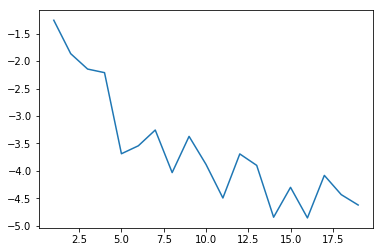

In [124]:
# build a lda topic model (number of topics = 20, passes = 20, eval_every=1)
numpy.random.seed(1) # setting random seed to get the same results each time. 
k_range = range(1,20)   
scores = []
for k in k_range:
    goodLdaModel = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=20, eval_every=1)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    print (k, goodcm.get_coherence())
    scores.append(goodcm.get_coherence())

# Plot
plt.figure()
plt.plot(k_range, scores)

In [125]:
# Report on topics found in modeling above
goodLdaModel.show_topics(num_topics=15, num_words=10, log=False, formatted=True)

[(5,
  '0.034*"delivery" + 0.022*"day" + 0.018*"company" + 0.018*"would" + 0.017*"call" + 0.016*"back" + 0.014*"woman" + 0.013*"get" + 0.012*"could" + 0.012*"going"'),
 (9,
  '0.024*"call" + 0.020*"called" + 0.019*"told" + 0.018*"installation" + 0.015*"back" + 0.014*"tuesday" + 0.013*"day" + 0.012*"delivered" + 0.012*"appliances" + 0.011*"customer"'),
 (12,
  '0.025*"would" + 0.023*"grill" + 0.017*"told" + 0.014*"never" + 0.013*"process" + 0.012*"customer" + 0.010*"scheduled" + 0.009*"get" + 0.009*"going" + 0.008*"could"'),
 (11,
  '0.024*"manager" + 0.020*"finish" + 0.016*"ordered" + 0.016*"good" + 0.015*"store" + 0.015*"shopping" + 0.015*"always" + 0.015*"cabinets" + 0.015*"buying" + 0.011*"wrong"'),
 (3,
  '0.016*"help" + 0.016*"service" + 0.015*"customer" + 0.015*"store" + 0.013*"never" + 0.013*"call" + 0.012*"told" + 0.012*"order" + 0.011*"wrong" + 0.011*"took"'),
 (15,
  '0.020*"customer" + 0.019*"store" + 0.018*"order" + 0.014*"ordered" + 0.014*"called" + 0.013*"told" + 0.013*"s

In [126]:
# print words without probability
for i in range(1,15):
    topics = goodLdaModel.show_topic(i, 10)
    print(', '.join([str(word[0]) for word in topics]))

card, site, would, sales, new, months, check, store, take, attitude
service, store, like, refrigerator, saw, battery, manager, help, making, work
help, service, customer, store, never, call, told, order, wrong, took
customer, service, battery, ryobi, grill, bought, paint, buy, would, tool
delivery, day, company, would, call, back, woman, get, could, going
refrigerator, delivery, would, day, microwave, range, went, store, boards, purchase
store, delivery, ordered, would, time, cabinets, appliances, contractor, online, order
store, customers, even, give, would, great, right, experience, money, time
call, called, told, installation, back, tuesday, day, delivered, appliances, customer
valve, new, foot, install, delivery, told, plumber, hose, would, dryer
manager, finish, ordered, good, store, shopping, always, cabinets, buying, wrong
would, grill, told, never, process, customer, scheduled, get, going, could
information, well, employees, lowe, looks, several, went, made, screws, like
call, 

In [127]:
import pyLDAvis.gensim

In [128]:
# Show Intertopic Distance Map to help visualize topics. 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(goodLdaModel, corpus, dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057296  0.067183  1       1        3.698146 
1      0.071459 -0.019159  2       1        0.945834 
2      0.051393  0.043189  3       1        6.138348 
3     -0.040134  0.024006  4       1        7.757279 
4      0.035062 -0.082236  5       1        4.412659 
5     -0.138893  0.024112  6       1        11.953443
6     -0.009084  0.016843  7       1        2.285594 
7     -0.038173  0.021803  8       1        8.143295 
8      0.059840  0.062109  9       1        5.906854 
9     -0.109149 -0.002467  10      1        5.269368 
10    -0.011186 -0.151384  11      1        7.053808 
11     0.121983  0.123371  12      1        2.148495 
12     0.021345  0.004880  13      1        4.809947 
13     0.186264 -0.061256  14      1        1.508002 
14    -0.130896  0.059351  15      1        8.955180 
15    -0.035128  0.035483  16      1        4.739888 
16    -0.063399 -0.181334  17      1        5.281538 
17     0.030424  0.063068  18      1        1.704681 
18     0.055566 -0.047563  19      1        7.287636 , topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
71    Default  82.000000  store         82.000000  30.0000  30.0000
144   Default  59.000000  order         59.000000  29.0000  29.0000
91    Default  76.000000  delivery      76.000000  28.0000  28.0000
129   Default  18.000000  card          18.000000  27.0000  27.0000
33    Default  17.000000  dishwasher    17.000000  26.0000  26.0000
107   Default  33.000000  new           33.000000  25.0000  25.0000
20    Default  48.000000  called        48.000000  24.0000  24.0000
157   Default  87.000000  would         87.000000  23.0000  23.0000
60    Default  15.000000  refrigerator  15.000000  22.0000  22.0000
186   Default  22.000000  well          22.000000  21.0000  21.0000
19    Default  66.000000  call          66.000000  20.0000  20.0000
161   Default  13.000000  grill         13.000000  19.0000  19.0000
801   Default  13.000000  battery       13.000000  18.0000  18.0000
132   Default  50.000000  day           50.000000  17.0000  17.0000
145   Default  31.000000  ordered       31.000000  16.0000  16.0000
284   Default  25.000000  went          25.000000  15.0000  15.0000
48    Default  22.000000  manager       22.000000  14.0000  14.0000
255   Default  26.000000  like          26.000000  13.0000  13.0000
327   Default  25.000000  installation  25.000000  12.0000  12.0000
195   Default  27.000000  even          27.000000  11.0000  11.0000
180   Default  26.000000  th            26.000000  10.0000  10.0000
25    Default  19.000000  check         19.000000  9.0000   9.0000 
106   Default  55.000000  never         55.000000  8.0000   8.0000 
475   Default  13.000000  valve         13.000000  7.0000   7.0000 
104   Default  12.000000  months        12.000000  6.0000   6.0000 
204   Default  25.000000  online        25.000000  5.0000   5.0000 
319   Default  11.000000  sales         11.000000  4.0000   4.0000 
29    Default  64.000000  customer      64.000000  3.0000   3.0000 
551   Default  14.000000  cabinets      14.000000  2.0000   2.0000 
594   Default  15.000000  door          15.000000  1.0000   1.0000 
...       ...        ...       ...            ...     ...      ... 
938   Topic19  0.941682   wonderful     2.418269   1.6759  -6.3210 
935   Topic19  0.941680   pleased       2.418267   1.6759  -6.3210 
853   Topic19  0.941496   listened      2.418118   1.6757  -6.3212 
129   Topic19  7.249591   card          18.821228  1.6650  -4.2800 
889   Topic19  2.692194   second        7.219296   1.6326  -5.2705 
126   Topic19  5.414857   box           15.819463  1.5469  -4.5718 
89    Topic19  4.519285   damaged       13.431568  1.5297  -4.7525 
280   Topic19  1.836238   turned        5.107034   1.5961  -5.6532 
460   Topic19  1.835932   simply   

The first thing that jumps out when viewing the Intertopic Distance Map above is that there is a substantial amount of clustering between topics showing a large correlation. The largest cluster clearly occuring between topics 4, 7, 18, 19, 3, 2, 16, 9, and 12. Another important trend found in analyzing the topic distribution is that there are a number of words occuring very frequently accross topics. This high frequency words include, "Delivery", "Service", "Weeks", "Store", "Ordered", etc. 

# 7. Kansas Homedepot Stores Marketing Analytics

Homedepot is currently behind the ball when it comes to newly developed marketing techniques availible. Presently, all of Homedepot's marketing endevors come directly from the corporate office (Atlanta, Georgia) and don't take customers regional needs into consideration. When applying a broad approach such as that currently in use by the Homedepot, many potential customers can be lost in given the large economic, meteorological, socialogical, and economic differences that occur accross the county... even the state for that matter. Considering this fact, the following analysis aims to help develop an individualized marketing approach for each store in Kansas.

### 7.1 Kansas Weather Analysis

In [129]:
# Merge alldata_df dataframe with best_worst dataframe to have a single df with all information. 
Store_weather = pd.merge(stores, weather, on='County')

In [130]:
# Print List of stores that correlate to the same county issuing a severe weather alert.
Store_weather

,Store,Address,City,County,State,Zip,Phone
0,ï»¿E. Wichita,3350 N. Woodlawn,Wichita,Sedgwick,KS,67220,(316) 681-0899
1,ï»¿E. Wichita,3350 N. Woodlawn,Wichita,Sedgwick,KS,67220,(316) 681-0899
2,W. Wichita,8444 W. McCormick Ave.,Wichita,Sedgwick,KS,67209,(316) 773-1988
3,W. Wichita,8444 W. McCormick Ave.,Wichita,Sedgwick,KS,67209,(316) 773-1988
4,Lawrence,1910 W. 31st Street,Lawrence,Douglas,KS,66046,(785) 749-2074
5,Hays,1310 E. 41st St.,Hays,Ellis,KS,67601,(785) 625-0044
6,Hays,1310 E. 41st St.,Hays,Ellis,KS,67601,(785) 625-0044
7,Topkea,5900 SW. Huntoon,Topeka,Shawnee,KS,66604,(785) 272-5949
8,Hutchinson,1907 E. 17th Ave.,Hutchinson,Reno,KS,67501,(785) 728-0460


### 7.2 Kansas County Income Analysis

In [131]:
# Merge alldata_df dataframe with best_worst dataframe to have a single df with all information. 
Store_income = pd.merge(stores, KS_data, on='County')
Store_income.head(5)

,Store,Address,City,County,State,Zip,Phone,Rank,Per Capita Income,Mediam Household Income,Median Family Income,Population,Number of Households
0,ï»¿E. Wichita,3350 N. Woodlawn,Wichita,Sedgwick,KS,67220,(316) 681-0899,11,"$25,297","$47,848","$61,137","498,365","193,502"
1,W. Wichita,8444 W. McCormick Ave.,Wichita,Sedgwick,KS,67209,(316) 773-1988,11,"$25,297","$47,848","$61,137","498,365","193,502"
2,Lawrence,1910 W. 31st Street,Lawrence,Douglas,KS,66046,(785) 749-2074,19,"$24,851","$45,831","$68,282","110,826","43,576"
3,N. Overland Park,9600 Metcalf Ave.,Overland Park,Johnson,KS,66212,(913) 648-7811,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
4,S. Overland Park KS,8000 W. 135th St.,Overland Park,Johnson,KS,66223,(913) 851-9961,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"


In [132]:
# Sort by Median Family Income 
Store_income = Store_income.sort_values(['Median Family Income'], ascending=[False])
Store_income

,Store,Address,City,County,State,Zip,Phone,Rank,Per Capita Income,Mediam Household Income,Median Family Income,Population,Number of Households
3,N. Overland Park,9600 Metcalf Ave.,Overland Park,Johnson,KS,66212,(913) 648-7811,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
4,S. Overland Park KS,8000 W. 135th St.,Overland Park,Johnson,KS,66223,(913) 851-9961,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
5,Olathe,11850 S. Strang Line Rd.,Olathe,Johnson,KS,66062,(913) 768-1600,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
6,Shawnee,15501 W. 67th St.,Shawnee,Johnson,KS,66217,(913) 631-1005,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
7,Merriam,5700 Antioch Ave.,Merriam,Johnson,KS,66202,(913) 789-8899,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
8,S. Olathe,20025 W. 154th St.,Olathe,Johnson,KS,66062,(913) 780-6933,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
10,Leavenworth,5000 S. 4th St.,Leavenworth,Leavenworth,KS,66048,(913) 727-1978,8,"$25,925","$61,107","$73,491","76,227","26,447"
2,Lawrence,1910 W. 31st Street,Lawrence,Douglas,KS,66046,(785) 749-2074,19,"$24,851","$45,831","$68,282","110,826","43,576"
11,Hays,1310 E. 41st St.,Hays,Ellis,KS,67601,(785) 625-0044,22,"$24,093","$44,543","$62,176","28,452","11,908"
13,Topkea,5900 SW. Huntoon,Topeka,Shawnee,KS,66604,(785) 272-5949,9,"$25,705","$47,464","$61,250","177,934","72,600"


### 7.3 Kansas County Population Analysis

In [133]:
# Sort by population
Store_pop = Store_income.sort_values(['Population'], ascending=[False])
Store_pop

,Store,Address,City,County,State,Zip,Phone,Rank,Per Capita Income,Mediam Household Income,Median Family Income,Population,Number of Households
10,Leavenworth,5000 S. 4th St.,Leavenworth,Leavenworth,KS,66048,(913) 727-1978,8,"$25,925","$61,107","$73,491","76,227","26,447"
14,Hutchinson,1907 E. 17th Ave.,Hutchinson,Reno,KS,67501,(785) 728-0460,60,"$22,149","$41,431","$49,490","64,511","25,794"
3,N. Overland Park,9600 Metcalf Ave.,Overland Park,Johnson,KS,66212,(913) 648-7811,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
4,S. Overland Park KS,8000 W. 135th St.,Overland Park,Johnson,KS,66223,(913) 851-9961,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
5,Olathe,11850 S. Strang Line Rd.,Olathe,Johnson,KS,66062,(913) 768-1600,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
6,Shawnee,15501 W. 67th St.,Shawnee,Johnson,KS,66217,(913) 631-1005,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
7,Merriam,5700 Antioch Ave.,Merriam,Johnson,KS,66202,(913) 789-8899,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
8,S. Olathe,20025 W. 154th St.,Olathe,Johnson,KS,66062,(913) 780-6933,ï»¿1,"$37,882","$73,733","$90,380","544,179","212,882"
0,ï»¿E. Wichita,3350 N. Woodlawn,Wichita,Sedgwick,KS,67220,(316) 681-0899,11,"$25,297","$47,848","$61,137","498,365","193,502"
1,W. Wichita,8444 W. McCormick Ave.,Wichita,Sedgwick,KS,67209,(316) 773-1988,11,"$25,297","$47,848","$61,137","498,365","193,502"


I'm not sure why I am unable to sort the above chart by population... possibly because of the comma? In any case, sorting by population gives us yet another meaningful statistic to determine usefull marketing techniques.

# 8. Storytelling

As stated in the project overview above, the goal of this project was to analyze online comments (via twitter and review pages) along with the current events news to develop the most effective marketing strategy based on region. After having performed the above analysis, it is my personal opinion that all objectives were satisfactory completed... but as always, additional parameters could be analyized for a more complete real world application. 

**Sentiment Analysis**

Shown above in section 5, I completed a sentiment analysis for two different data sets (Twitter and Trustpilot reviews) to generate a more complete understanding of how customers generally feel about Home Depot as a company. Per the analysis results for both, we found that there was a close to a 50/50 split between possitive and negative reviews with very few neutral reviews. While this analysis alone does not provide us with any information for which to make an informed business decision, but it does set the tone for our continued analysis in identifying common trends related to positive and negative reviews. 

**Topic Modeling**

Our topic modeling analysis was completed in section 6 of the above analysis. Firstly, to reiterate that voiced above, only 180 reviews were collected from the trustpilot website which is not nearly as many reviews as I would have liked to have had for consturcting our model... given that the more reviews used in training our model the more accurate it becomes. However, for the purposes of this project I feel it has done the job. When looking at the Intertopic Distance Map the largest cluster clearly occuring between topics 4, 7, 18, 19, 3, 2, 16, 9, and 12. Another important trend found in analyzing the topic distribution is that there are a number of words occuring very frequently accross topics. This high frequency words include, "Delivery", "Service", "Weeks", "Store", "Ordered", etc. Given that our sentiment analysis produced mixed results its difficult to tell if these words relate to a positive or negative sentiment, but we can conclude that Delivery and Service are amoung some of the most discussed topics and therefore very important to the customer base. Moving forward, Home Depot should stress a high level of dedication to continued improvements in these areas from all of the staff members to ensure a satisfying customer experience. In addition, the company can use this insight to highlight positive examples of customer service and delivery via public platforms for marketing purposes. My suggestion would be to begin using the Home Depot twitter account to pursue this goal. 

**Statistical Analysis**

In my opinion, this is the most meaningful section (section 7) of the entire analysis. A significant amount of business insight can be gathered from this section alone. For instance, I first began by web scrapping the KWCH website for all severe weather alerts by county in Kansas. I then merged this pandas data frame with a complete list of Home Depot locations in Kansas to identify only those stores located within the affected county. It is my intention that the company use this information to market "weather specific" products that could assist the state inhabitants affected by the storm. To elaborate, each of these stores (on an individual level) could begin marketing items often made more desireable in severe weather conditions... generater, flashlight, batteries, radio, etc. It is my opinion that this tactic will provide a public service that will be appreciated while also increasing calls revenue as individuals prepare for adverse weather conditions in their area. 

Next, I continued by mining for Kansas census information that would provide meaningful business information such as average household income and population. In viewing this information, we can effectively determine regional sales prices, ideal store locations, anticipate which products will be more successful, and develop an indiviualized marketing strategy. To elaborate, we can increase our total sales revenue by dropping the price in lower income areas and therefore selling more product, while simultaniously increasing the sales price in high income areas. More analysis would be required to maximize the price per region but this provides the basis for those considerations. Also, its interesting to note that the majority of Home Depot stores are located in the top 11 counties based on average income. This certainly makes sense when we consider that in order to maximize revenue our store locations must be availible in locations where the largest proportion of wealth is held. In the event that Home Depot decides to move a larger portion of its business online by closing 'brick and mortar' locations, this can be an important consideration. 

**Areas For Continued Improvement**

As Home Depot continues to improve and grow as a business there will always be areas to improve upon its current marketing strategy. While my analysis highlights a number of possible avenues for future development, I unfortunately don't have access to company specific information that could be used at this time. For example, I would like to see Home Depot adopt the "reward card member" customer approach already utilized by companines like Dilions, Target, American Eagle, etc. These companies can track all purchases associated with the customers card and then make future purchasing suggestions based on individuals purchasing history. This approach also provides the company with the customers contact information allowing for easier access to distributing individualized marketing material. 